In [507]:
import pandas as pd
import numpy as np

In [508]:
## Open file
number_samples = 6
bracken_file=pd.read_csv(filepath_or_buffer='/home/labcompjavier/juanPicon/biocomp_tools/MAUS/utils/all_bracken_report_V3-V4.txt', 
                        delimiter='\t', skiprows=8)

In [509]:
import os
alpha_diversity_raw={"sample":[], "shannon":[], "simpson_reciprocal":[]}
for i in os.listdir():
    if i.startswith("G"):
        handler=open(i)
        handler=handler.readlines()
        ## select lines 0 and 3 which are Shannon and Simpson's Reciprocal Index
        alpha_diversity_raw["sample"].append(i[:4])
        alpha_diversity_raw["shannon"].append(round(float(handler[0].split(" ")[2].strip()),2))
        alpha_diversity_raw["simpson_reciprocal"].append(round(float(handler[3].split(" ")[3].strip()),2))
alpha_data=pd.DataFrame(alpha_diversity_raw)
alpha_data.sort_values(by="sample",inplace=True)

In [510]:
## compute relative abundance (RelAbun)
def compute_relative_abun (df, number_samples=6):
    for i in range(1, number_samples+1):
        i = str(i)
        df[f"G{i}_1_RelAbun"] = df[f"G{i}_1_lvl"]/df[f"G{i}_1_lvl"].sum() * 100
    return df

In [511]:
bracken_file=compute_relative_abun(df=bracken_file, number_samples=number_samples)
min_abundance=1
def filter_by_abundance_conditional (df, number_samples, min_abundance, min_samples):
    ## This is intended to mimic the taxa filter by abundance conditionally of qiime2
    ## Select taxa that have at least n abundance in at least n samples 
    df = df[(df.iloc[:,number_samples*-1:] >= min_abundance).sum(axis=1) >= min_samples]
    return df

bracken_file = filter_by_abundance_conditional (df=bracken_file, 
                                                number_samples=number_samples,
                                                min_abundance=min_abundance, 
                                                min_samples=2)
bracken_file=compute_relative_abun(df=bracken_file, number_samples=number_samples)

In [512]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [513]:
bracken_file_relative_abun=bracken_file.loc[:,"name":]
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

sample_names=bracken_file_relative_abun.iloc[:,1:].columns
bracken_file_relative_abun["name"] = bracken_file_relative_abun["name"].apply(lambda x:x.strip())

# Number of bars
num_bars = len(bracken_file_relative_abun["name"])

# Generate colors using a predefined colorscale (Viridis, Cividis, etc.)
colors = px.colors.sample_colorscale('spectral', np.linspace(0, 1, num_bars))

## Composition bars
for i in range(0, len(bracken_file_relative_abun["name"])):
        fig.add_bar(name=bracken_file_relative_abun.iloc[i,0].strip(),
                        x=sample_names,y=bracken_file_relative_abun.iloc[i,1:],
                        row=2, col=1, marker=dict(color=colors[i])
                    )

## Diversity bars
width=0.4
offset=0.2
fig.add_bar(y=alpha_data["shannon"].to_list(), showlegend=False,
                        row=1, col=1, width=width,offset=offset,
                        text="shannon", textangle=360, textposition='outside'
                    )
fig.add_bar(y=alpha_data["simpson_reciprocal"], showlegend=False,
                        row=1, col=1, width=width,
                        text="simpson", textangle=360, textposition='outside'
                    )

fig.update_layout(barmode='stack',
    autosize=True,
    width=1200,
    height=800,
    title_text="Relative abundance V3-V4 Kraken2-Bracken"
    )


## Composition bars
fig.update_yaxes(title_text="Relative frequency (%)", row=2, col=1)
fig.update_xaxes(title_text="Samples", row=2, col=1)

## Diversity bars
fig.update_traces(dict(base='group'), row=1, col=1, overwrite=True)
fig.update_yaxes(dict(title_text="Value", tickmode="linear", tick0=0, dtick=5), row=1, col=1, overwrite=True)



In [514]:
import seaborn as sns
import matplotlib.pyplot as plt

In [515]:
duplicates=bracken_file_relative_abun["name"].duplicated()
for i in bracken_file_relative_abun[duplicates].index:
    bracken_file_relative_abun.loc[i,"name"] = bracken_file_relative_abun.loc[i,"name"] + str(i)
bracken_file_relative_abun.set_index(keys="name",inplace=True)
bracken_file_relative_abun.head()

,G1_1_RelAbun,G2_1_RelAbun,G3_1_RelAbun,G4_1_RelAbun,G5_1_RelAbun,G6_1_RelAbun
name,,,,,,
Pseudomonas,9.143152,2.377387,37.917381,26.975064,31.096310,27.970466
Thiopseudomonas,2.849671,0.109726,0.193280,10.643450,1.360833,0.413500
Advenella,1.139191,0.210480,2.208617,13.180878,1.213245,1.770403
Parapusillimonas,0.232747,0.038645,0.236115,2.392945,2.132829,0.512984
Thauera,0.006771,0.024153,0.078357,1.282415,1.967077,18.242050


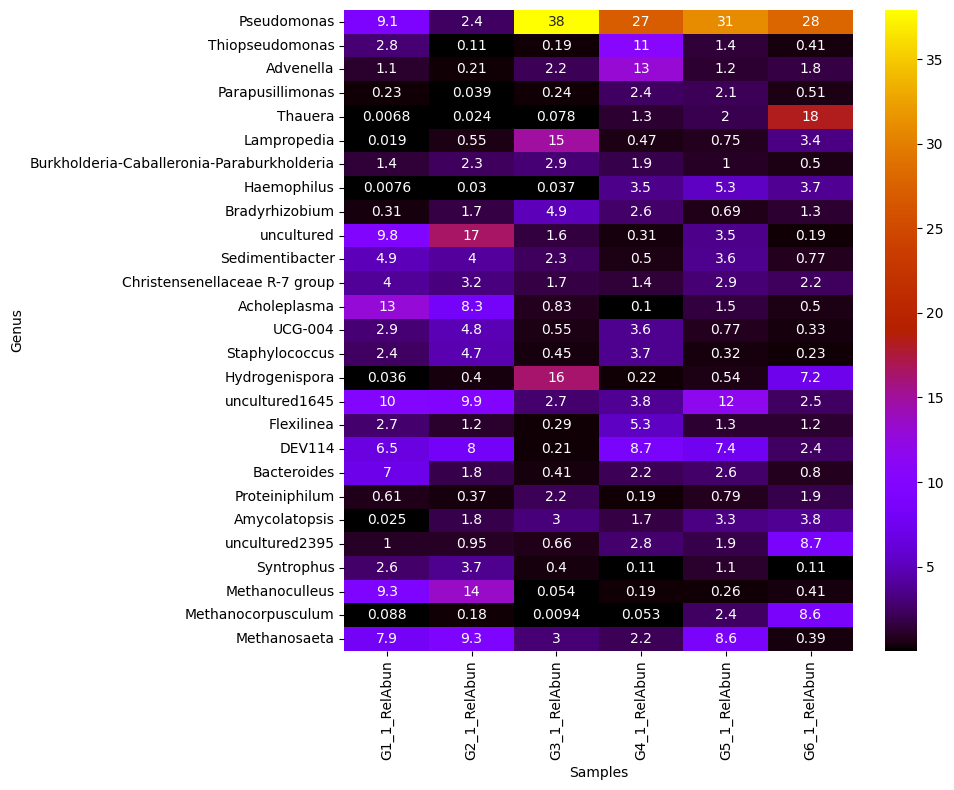

In [516]:
fig = plt.figure(figsize=(10,8))
heatmap=sns.heatmap(bracken_file_relative_abun, cmap="gnuplot", annot=True)
heatmap.set_ylabel("Genus")
heatmap.set_xlabel("Samples")
plt.xticks(rotation=90)
plt.tight_layout()
#fig.savefig('heatmap_samples_vs_genus.png', format='png', dpi=1200)

In [517]:
bracken_file.head()

,#perc,tot_all,tot_lvl,G1_1_all,G1_1_lvl,G2_1_all,G2_1_lvl,G3_1_all,G3_1_lvl,G4_1_all,...,G6_1_lvl,lvl_type,taxid,name,G1_1_RelAbun,G2_1_RelAbun,G3_1_RelAbun,G4_1_RelAbun,G5_1_RelAbun,G6_1_RelAbun
7,14.4211,187100,187100,10803,10803,3445,3445,36293,36293,54143,...,41330,G,3723,Pseudomonas,9.143152,2.377387,37.917381,26.975064,31.096310,27.970466
8,2.1183,27483,27483,3367,3367,159,159,185,185,21363,...,611,G,14683,Thiopseudomonas,2.849671,0.109726,0.193280,10.643450,1.360833,0.413500
103,2.6545,34440,34440,1346,1346,305,305,2114,2114,26456,...,2616,G,46191,Advenella,1.139191,0.210480,2.208617,13.180878,1.213245,1.770403
106,0.6888,8936,8936,275,275,56,56,226,226,4803,...,758,G,46206,Parapusillimonas,0.232747,0.038645,0.236115,2.392945,2.132829,0.512984
129,2.4854,32246,32246,8,8,35,35,75,75,2574,...,26955,G,46425,Thauera,0.006771,0.024153,0.078357,1.282415,1.967077,18.242050


<Figure size 1000x800 with 0 Axes>

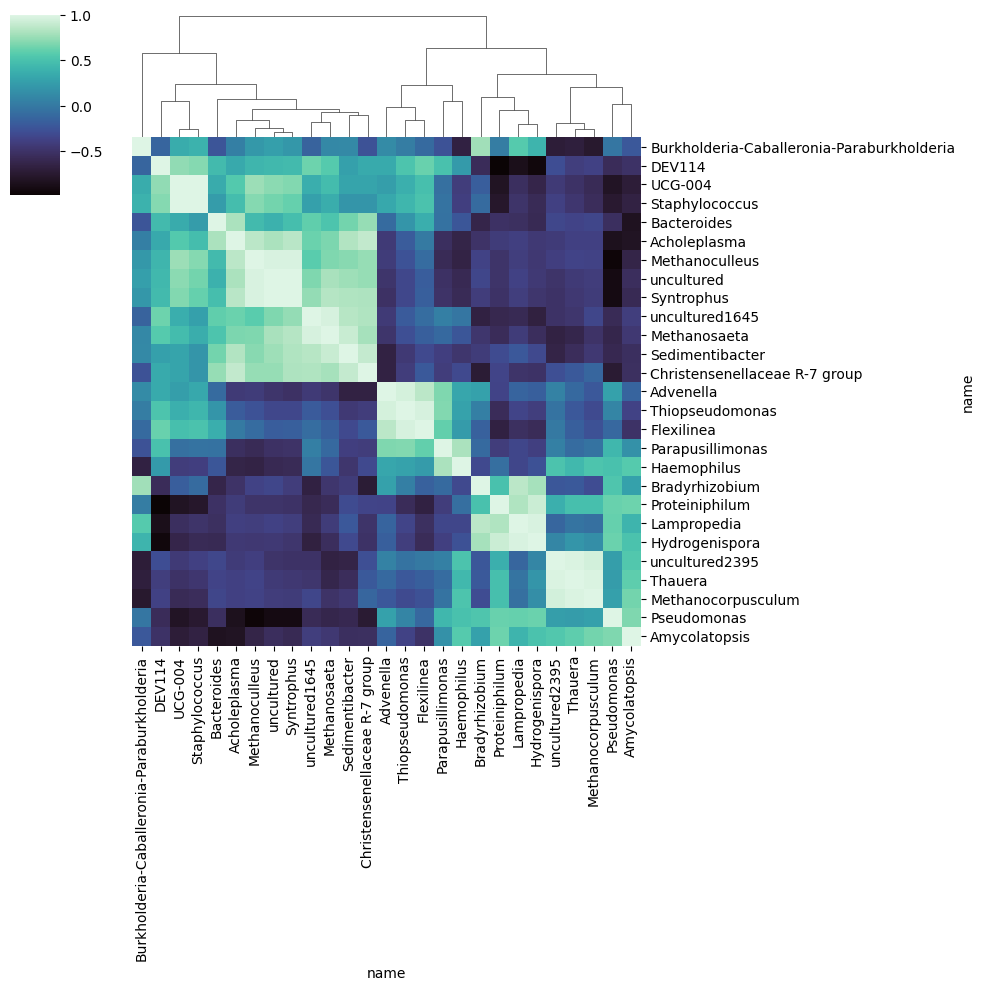

In [518]:
fig = plt.figure(figsize=(10,8))
correlation=bracken_file_relative_abun.T.corr()
cluster_plot = sns.clustermap(correlation, cmap="mako")
cluster_plot.ax_row_dendrogram.remove()
#fig.savefig('clustermap_samples_vs_genus.png', format='png', dpi=1200)
cluster_plot.savefig('clustermap_samples_vs_genus.png', format='png', dpi=1200)